In [1]:
%load_ext autoreload
%autoreload 2

%pylab inline
import sys, fiona
sys.path.append("../")
sys.path.insert(0,"/home/luca/Code/topojson.git/")
import mappy as mpy
import geopandas

Populating the interactive namespace from numpy and matplotlib


# interesting link for checking overlaps
https://medium.com/@achm.firmansyah/an-approach-for-checking-overlaps-and-gaps-in-polygons-using-geopandas-ebd6606e7f70

In [2]:
infile = "/home/luca/Code/mappy.git/input_data/build_map.gpkg"
layer_name  = "geomap"
column_name="unit_name"

# infile = "/home/luca/Code/mappy.git/input_data/test_map.gpkg"
# layer_name  = "test_map"
# column_name="name"


infile = "/data/SciDataHub/projects/map_validation/PM-MOO-MS-SPAApollo_01.gpkg"
layer_name= "subregion_fixed"
column_name="Unit_Code"

# infile = "/home/luca/geomap.gpkg"
# layer_name = "geomap"
# column_name = "Unit_name"


# infile = "/data/SciDataHub/projects/map_validation/PM-MOO-MS-SPAApollo_01_2.gpkg"
# layer_name= "subregion_fixed"
# column_name="Unit_Code"



In [4]:
import geopandas as gpd
from mappy.mappy_logging import logger as log
import logging
log.setLevel(logging.DEBUG)

In [5]:
fiona.listlayers(infile)

['subregion_fixed']

In [6]:
polygons = gpd.read_file(infile, layer=layer_name)
polygons.geometry = polygons.buffer(0)
polygons = mpy.explode_multipolygons(polygons)
polygons = mpy.remove_null_geometries(polygons) 
polygons =  mpy.remove_truly_duplicated_geometries(polygons)

polygons.reset_index(inplace=True)

/home/luca/.local/lib/python3.8/site-packages/descartes/patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +
/home/luca/.local/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


<AxesSubplot:>

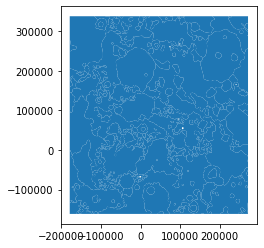

In [7]:
polygons.plot()

In [8]:
todrop = []
for id, p in enumerate(polygons.geometry):
    if p.area < 1e-6:
#         print("null area")
        todrop.append(id)
        
        
polygons.drop(todrop, inplace=True)
print(len(polygons))

259


In [9]:
mpy.check_validity_of_geometries(polygons)

In [10]:
polygons.to_file("dissolved.gpkg", layer="dissolved", driver="GPKG")

In [11]:
aspd = mpy.generate_label_points(polygons)

In [12]:
aspd = mpy.transfer_polygons_fields_to_points(aspd, polygons)

../mappy/geom_ops.py:220: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["unknown", ...

  with_fields = geopandas.sjoin(points, polygons)


/home/luca/.local/lib/python3.8/site-packages/descartes/patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +
/home/luca/.local/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


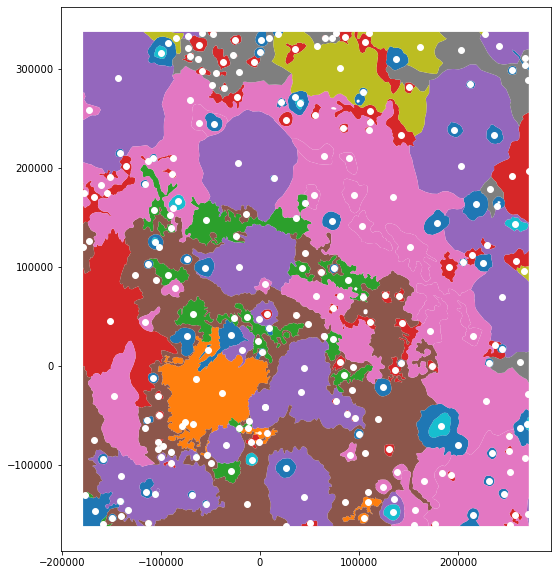

In [13]:
figure(figsize=(10,10))
polygons.plot(column=column_name,ax=gca())
aspd.plot(ax=gca(), color="white", markersize=35)
aspd.to_file("indicator_points.gpkg", driver="GPKG", layer="points")

In [14]:
mpy.check_validity_of_geometries(polygons)

In [15]:
import shapely.ops

/home/luca/.local/lib/python3.8/site-packages/descartes/patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +


<AxesSubplot:>

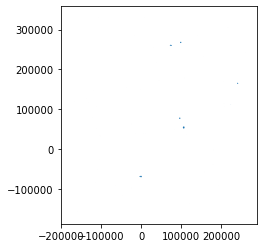

In [16]:
union = shapely.ops.cascaded_union(polygons.geometry)

out = []
for i in union.interiors:
#     print(i)
    out += [i]
    
inside = [shapely.geometry.Polygon(l) for l in out]

full = geopandas.GeoDataFrame(geometry=inside)




full.plot()

In [17]:
full.to_file("unified.gpkg", layer="unified", driver="GPKG")

In [28]:

import topojson
# tj = topojson.Topology(polygons,prequantize=False,topoquantize=True, shared_coords=False, toposimplify=True, presimplify=False)
tj = topojson.Topology(polygons, prequantize=False)

# tj = tj.toposimplify(0.1).topoquantize(1e12)
asgdf = tj.to_gdf()
asgdf.to_file("topojsoned.gpkg", layer="topojsoned", driver="GPKG")

/usr/lib/python3.8/site-packages/numpy/core/shape_base.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  ary = asanyarray(ary)


In [29]:
# asgdf.to_file("topojsoned.gpkg", layer="topojsoned", driver="GPKG")

In [30]:
import mappy

In [31]:
self = mappy.geom_ops.compute_self_intersections_points(asgdf)

In [32]:
self.to_file("self.gpkg", layer="self",driver="GPKG")

In [33]:

# arc_ids = tj.output["objects"]["data"]["geometries"][4]["arcs"][0]


# for id in arc_ids:
#     if id < 0:
#         id = -id-1
#     pts = tj.output["arcs"][np.abs(id)]
#     pts = np.cumsum(np.array(pts), axis=0)
#     plot(*pts.T)

In [34]:
# len(tj.output["arcs"])

In [35]:
import topojson, copy
from topojson.ops import np_array_from_arcs


def extract_numpy_arcs(topology):
    t=None
    if "transform" in topology.output.keys():
        s = np.array(topology.output["transform"]["scale"])
        t = np.array(topology.output["transform"]["translate"])
    top = topology._resolve_coords(topology.output)
    np_arcs = np_array_from_arcs(top["arcs"])
    if t is not None:
        out = topojson.ops.dequantize(np_arcs, s, t)
    else:
        out = np_arcs

    out = [o[~np.isnan(o).any(axis=1)] for o in out]
    
    return out

out = extract_numpy_arcs(tj)

<ipython-input-36-955a0c5bd73a>:3: ShapelyDeprecationWarning: The proxy geometries (through the 'asShape()', 'asLineString()' or 'LineStringAdapter()' constructors) are deprecated and will be removed in Shapely 2.0. Use the 'shape()' function or the standard 'LineString()' constructor instead.
  glines = [asLineString(e) for e in out]


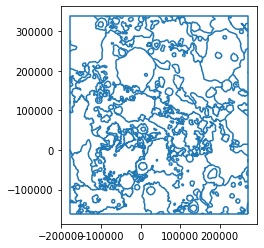

In [36]:
import shapely
from shapely.geometry import asLineString
glines = [asLineString(e) for e in out]
asg = geopandas.GeoDataFrame(geometry=glines)
asg.plot()
show()

asg.to_file("lines.gpkg", layer="lines", driver="GPKG")

In [ ]:
import itertools
for l1, l2 in itertools.combinations(asg.geometry, 2):
    if l1.overlaps(l2):
        print("o")
        a, b = l1, l2

In [ ]:
a

In [23]:
# asg.drop_duplicates?

In [42]:
import itertools
intersections = []
counter = 0
for id1, id2 in itertools.combinations(list(asg.index.values), 2):
    l1 = asg.geometry[id1]
    l2 = asg.geometry[id2]
    
    if l1.intersects(l2):
        print("int")

int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int
int


KeyboardInterrupt: 

In [1289]:
def reorder_points( points):
    startid = np.argmax(points[:,1])
    ids = np.arange(len(points))
    if startid != 0:
        out = np.row_stack([points[startid:, :], points[1:startid, :], points[startid, :]])
        ids = np.concatenate([ids[startid:], ids[1:startid], [ids[startid]]])
        
        return out, ids
    else:
        return points, ids
    
# a = np.random.randn(10,2)
# a[-1:] = a[0]

# print(a)
# reorder_points(a)

[[ 1.01567745 -0.75005481]
 [ 1.32740412 -0.49419332]
 [-0.41099023 -0.71258542]
 [ 0.21769176 -0.32336864]
 [-0.0463526   0.27408806]
 [ 0.5804946  -0.21407073]
 [ 0.34272781  0.20960311]
 [ 1.31421401  0.7438521 ]
 [-0.13472647 -0.12055653]
 [ 1.01567745 -0.75005481]]


(array([[ 1.31421401,  0.7438521 ],
        [-0.13472647, -0.12055653],
        [ 1.01567745, -0.75005481],
        [ 1.32740412, -0.49419332],
        [-0.41099023, -0.71258542],
        [ 0.21769176, -0.32336864],
        [-0.0463526 ,  0.27408806],
        [ 0.5804946 , -0.21407073],
        [ 0.34272781,  0.20960311],
        [ 1.31421401,  0.7438521 ]]),
 array([7, 8, 9, 1, 2, 3, 4, 5, 6, 7]))

In [1290]:


import attr
@attr.attrs(eq=False)
class Arc:
    points = attr.ib(repr=False)
    real_points = attr.ib(repr=False)
    id = attr.ib()
    separating_polygons = attr.ib(factory=list, repr=False)
    
    def __attrs_post_init__(self):
        if self.is_closed():
            
            self.real_points, ids = reorder_points(self.real_points)
            newpts = np.cumsum(self.points, axis=0)
            rearranged = newpts[ids]
            newpts = np.row_stack([rearranged[0], np.diff(rearranged, axis=0)])
            self.points = newpts
            
    
    def plot(self, *attrs, **kwattrs):
        plot(*np.cumsum(self.points, axis=0).T, *attrs, **kwattrs)
        
    def plot_real(self, *attrs, **kwattrs):
        plot(*self.real_points.T, *attrs, **kwattrs)
        
    def is_closed(self):
        if np.all(self.real_points[0] == self.real_points[-1]):
            return True
        else:
            return False
        
    def get_points(self, invert=False):
        if invert:
            return self.real_points[::-1]
        else:
            return self.real_points
        
    def as_shapely(self, invert=False):
        return shapely.geometry.LineString(self.real_points)
    
@attr.attrs(eq=False)
class Polygon:
    arcs = attr.ib(factory=list, repr=True) 
    
    
    
    def has_holes(self):
        if len(self.arcs) > 1:
            return True
        else:
            return False
        
    def as_shapely(self):
        ext_points = []
        for arc, order in self.arcs[0]:
            ext_points.append(arc.get_points(order))
            
        ext_points = np.row_stack(ext_points)
        
        inners = []
        for inner in self.arcs[1:]:
            ring = []
            for arc, order in inner:
                ring.append(arc.get_points(order))
                
            ring = np.row_stack(ring)
            inners.append(ring)
            
        pp = shapely.geometry.Polygon(ext_points, inners)
        return pp
    
    
        
    
            
        

        


In [1291]:
p

Polygon(arcs=[array([[Arc(id=1484), False],
       [Arc(id=1485), False],
       [Arc(id=1486), False],
       [Arc(id=1487), False],
       [Arc(id=1488), False],
       [Arc(id=1489), False],
       [Arc(id=1490), False],
       [Arc(id=1491), False],
       [Arc(id=1492), False]], dtype=object)])

In [1311]:
arcs = [Arc(points=np.array(arc_pts),real_points=real, id=id) for id, (arc_pts, real) in enumerate(zip(tj.output["arcs"], out))]
len(arcs)

1493

In [1293]:
pure_lines = geopandas.GeoDataFrame(geometry=[a.as_shapely() for a in arcs])
pure_lines.to_file("pure_lines.gpkg", layer="pure_lines", driver="GPKG")

In [1294]:
def retrive_arcs_as_objects(ids, objectslist):
    ids = np.array(ids)
    reverse = ids < 0
    
    ids[reverse] = -ids[reverse]-1
    arcs = np.array(objectslist)[ids]
    polarity = reverse
    
    return np.column_stack([arcs,polarity])

def retrieve_polygon(pol):
    out=[]
    for arclist in pol["arcs"]:
        out.append(retrive_arcs_as_objects(arclist, arcs))
    
    p = Polygon(out)
    for l in out:
        for arc, order in l:
            if p not in arc.separating_polygons:
                arc.separating_polygons.append(p)
    return  p
    
def retrieve_all_polygons(geometries):
    return [retrieve_polygon(g) for g in geometries]
    

polygons = retrieve_all_polygons(tj.output["objects"]["data"]["geometries"])

In [1295]:
oo = []
for id, p in enumerate(polygons):
    try:
        opols = p.as_shapely()
        
    except:
        print(id)
        continue
    oo.append(opols)
        
geopandas.GeoDataFrame(geometry=oo).to_file("reconstructed.gpkg", layer="recon", driver="GPKG")

In [1296]:
polygons[225]

Polygon(arcs=[array([[Arc(id=983), False],
       [Arc(id=984), False],
       [Arc(id=985), False],
       [Arc(id=986), False]], dtype=object)])

In [1297]:
closed_arcs = []

for arc in arcs:
    if arc.is_closed():
        closed_arcs.append(arc)

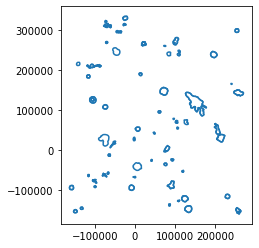

In [1298]:
import geopandas
gg = geopandas.GeoDataFrame(geometry=[a.as_shapely() for a in closed_arcs])
gg.plot()

gg.to_file("closed_arcs.gpkg", layer="closed", driver="GPKG")

In [1299]:
def replace_arc_in_polygon(polygon, original_arc, new_arc, invert=False):
    for item in polygon.arcs:
        for row in item:
            if row[0] == original_arc:
                print(f"old {item}")
                row[0] = new_arc
                
                if invert:
                    row[1] = not row[1]
                    
                print(f"new {item}")
            


In [1300]:
import itertools
newarcs = []
total = 0

duplicated = []
for arc, arc2, in itertools.combinations(arcs, 2):
    
        inverted = False
        replace = False
        if np.all(arc.real_points == arc2.real_points):
            duplicated.append(arc)
            replace = True
            
        elif np.all(arc.real_points == arc2.real_points[::-1]):
            
            duplicated.append(arc)
            inverted = True
            replace=True
            
#         elif np.all(arc.real_points[[0,-1]] == arc2.real_points[[0,-1]]):
#             print("shallow eq")
#             replace=True
            
#         elif np.all(arc.real_points[[0,-1]] == arc2.real_points[[0,-1]][::-1]):
#             print("shallow eq, inverted")
#             replace=True
#             inverted=True
            
        if replace:
            for pol in arc.separating_polygons:
                total +=1
                replace_arc_in_polygon(pol, arc, arc2, inverted)
            
            
            
            
            
            
            
print(total)                

<ipython-input-1300-b980760156e6>:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(arc.real_points == arc2.real_points):
<ipython-input-1300-b980760156e6>:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  elif np.all(arc.real_points == arc2.real_points[::-1]):


old [[Arc(id=4) False]]
new [[Arc(id=73) True]]
old [[Arc(id=8) False]]
new [[Arc(id=889) True]]
old [[Arc(id=9) False]]
new [[Arc(id=582) True]]
old [[Arc(id=11) False]]
new [[Arc(id=555) True]]
old [[Arc(id=12) False]]
new [[Arc(id=141) True]]
old [[Arc(id=19) False]]
new [[Arc(id=1219) True]]
old [[Arc(id=37) False]]
new [[Arc(id=1343) True]]
old [[Arc(id=38) False]]
new [[Arc(id=525) True]]
old [[Arc(id=41) False]]
new [[Arc(id=1463) True]]
old [[Arc(id=49) False]]
new [[Arc(id=1173) True]]
old [[Arc(id=50) False]]
new [[Arc(id=1174) True]]
old [[Arc(id=62) False]]
new [[Arc(id=599) True]]
old [[Arc(id=69) False]]
new [[Arc(id=1177) True]]
old [[Arc(id=72) False]]
new [[Arc(id=702) True]]
old [[Arc(id=74) False]]
new [[Arc(id=698) True]]
old [[Arc(id=86) False]]
new [[Arc(id=142) True]]
old [[Arc(id=120) False]]
new [[Arc(id=719) True]]
old [[Arc(id=121) False]]
new [[Arc(id=438) True]]
old [[Arc(id=124) False]]
new [[Arc(id=451) True]]
old [[Arc(id=125) False]]
new [[Arc(id=920) T

In [1301]:
used_arcs = []
for pol in polygons:
    for ring in pol.arcs:
        for arc, ori in ring:
            if arc not in used_arcs:
                used_arcs.append(arc)
asarcs = used_arcs         
used_arcs = [arc.as_shapely() for arc in used_arcs]            

In [1302]:
geopandas.GeoDataFrame(geometry=used_arcs).to_file("used_lines.gpkg", driver="GPKG", layer="used")

In [1303]:
total = 0
intersecting = []

for arc1, arc2, in itertools.combinations(asarcs, 2):
    a1 = arc1.as_shapely()
    a2 = arc2.as_shapely()
    
    if a1.intersects(a2):
        ints = a1.intersection(a2)
        if isinstance(ints, (shapely.geometry.Point, shapely.geometry.MultiPoint)):
            continue
        else:
            total +=1
            intersecting.append([arc1, arc2, ints])
            
print(total)

31


In [1304]:
intersecting

[[Arc(id=30),
  Arc(id=585),
 [Arc(id=30),
  Arc(id=1429),
 [Arc(id=54),
  Arc(id=513),
 [Arc(id=56),
  Arc(id=514),
 [Arc(id=58),
  Arc(id=547),
 [Arc(id=59),
  Arc(id=1218),
 [Arc(id=70),
  Arc(id=1059),
 [Arc(id=84),
  Arc(id=684),
 [Arc(id=85),
  Arc(id=684),
 [Arc(id=93),
  Arc(id=1351),
 [Arc(id=119),
  Arc(id=753),
 [Arc(id=156),
  Arc(id=828),
 [Arc(id=159),
  Arc(id=826),
 [Arc(id=160),
  Arc(id=261),
 [Arc(id=160),
  Arc(id=822),
 [Arc(id=247),
  Arc(id=834),
 [Arc(id=251),
  Arc(id=835),
 [Arc(id=281),
  Arc(id=1067),
 [Arc(id=283),
  Arc(id=1068),
 [Arc(id=347),
  Arc(id=1065),
 [Arc(id=348),
  Arc(id=1381),
 [Arc(id=356),
  Arc(id=1203),
 [Arc(id=407),
  Arc(id=618),
 [Arc(id=410),
  Arc(id=601),
 [Arc(id=435),
  Arc(id=752),
 [Arc(id=468),
  Arc(id=734),
 [Arc(id=528),
  Arc(id=1325),
 [Arc(id=789),
  Arc(id=1163),
 [Arc(id=1036),
  Arc(id=1221),
 [Arc(id=1045),
  Arc(id=1351),
 [Arc(id=1386),
  Arc(id=1427),

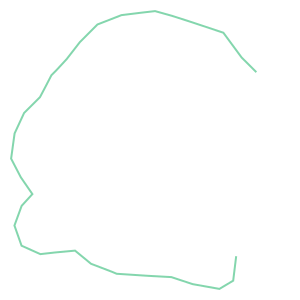

In [1305]:
intersecting[0][0].as_shapely()

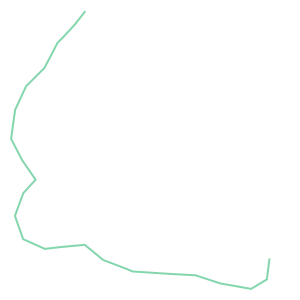

In [1306]:
intersecting[0][1].as_shapely()